<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 7 Tutorial: Regularised Linear Models</h2>
<br>

Our objective in this tutorial is to show you how to fit regularised linear models using scikit-learn and illustrate how you can use this approach in applications. 

While we are mostly focusing on structured data in our tutorials, this time we'll consider sentiment analysis, a natural language processing (NLP) application. Sentiment analysis is the task of classifying text documents according to the sentiment expressed by the author.  It has several applications in areas such as marketing, where online comments, reviews, and messages provide a wealth of data about customers that can be leveraged towards improving brand and customer relationship management strategies. 

A traditional method to address this problem is to use a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. In this approach, we represent the document as a numerical vector where each element counts how many times a word (or sequence of words) appears in the text or simply whether or not it appears in the text (leading to a binary vector). 

Because there are many possible words, a model of this type is bound to have a very large of number of features. This is exactly where regularisation can help!

In practice, the best approach to sentiment analysis currently is to fine-tune a large pre-trained neural network as we did in the first tutorial. Nevertheless, this tutorial builds a solid foundation for more advanced work. Regularisation is essential for all advanced learning algorithms.


<a href="#1.-Twitter-airline-sentiment-data">Twitter airline sentiment data</a> <br>
<a href="#2.-NLP-with-spaCy">NLP with spaCy</a> <br>
<a href="#3.-Text-processing">Text processing</a> <br>
<a href="#4.-Train-test-split">Train-test split</a> <br>
<a href="#5.-Some-EDA">Some EDA</a> <br>
<a href="#6.-Feature-engineering">Feature engineering</a> <br>
<a href="#8.-Logistic-regression">Logistic regression</a> <br>
<a href="#9.-Model-stacking">Model stacking</a> <br>
<a href="#10.-Model-selection">Model selection</a> <br>
<a href="#11.-Model-evaluation">Model evaluation</a> <br>


In [2]:
# Requirements 

import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import wordcloud
import sklearn

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'spacy {spacy.__version__}')
print(f'wordcloud {wordcloud.__version__}')
print(f'scikit-learn {sklearn.__version__}')

# Notebook tested on: 

# numpy 1.22.2
# scipy 1.7.1
# pandas 1.3.4
# seaborn 0.11.2
# spacy 3.2.2
# wordcloud 1.8.1
# scikit-learn 1.0.2

Package versions: 

numpy 1.20.3
scipy 1.3.1
pandas 1.2.5
seaborn 0.11.1
spacy 3.1.2
wordcloud 1.8.1
scikit-learn 1.0.1


In [3]:
# Optional configuration

# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [4]:
# Tools from  previous tutorials

from sklearn.model_selection import train_test_split, cross_val_score

# 1. Twitter airline sentiment data

We use the [Twitter Arline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset assembled by a company called [Crowdflower](https://www.crowdflower.com/) and made available [Kaggle datasets](https://www.kaggle.com/datasets) page. To build this dataset, the data scientists at Crowdflower scraped all tweets addressed at US airlines in the month of February 2015, including metadata about the message. Human contributors then categorised each tweet according to the sentiment (positive, neutral, or negative) expressed by the user, which can be done through services like [Amazon Mechanical Turk](https://www.mturk.com/).

In [9]:
data = pd.read_csv('Tweets.csv')
data.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [10]:
data.shape

(14640, 15)

In [6]:
(data["airline_sentiment_confidence"] == 1.0).mean()

0.7134562841530054

In sentiment analysis, it is common to use hierarchical classifiers that first classify a document as expressing a neutral or non-neutral sentiment, and then classify the sentiment in the documents that are predicted to have polarity. Therefore, we simplify our analysis to consider only positive and negatives tweets. Furthermore, we only keep the tweets that were classified with full confidence by the human labellers. 

In [11]:
data = data[data['airline_sentiment'] != 'neutral']
data = data[data['airline_sentiment_confidence'] == 1.0]

The filtered dataset has 8897 observations.

In [12]:
len(data)

8897

Our objective to build a classifier that achieves maximum accuracy in distinguishing between positive and negative sentiment.

In [16]:
data['positive'] = (data['airline_sentiment']=='positive').astype(int)

Here are examples of negative and positive tweets.

In [13]:
data.loc[4126, 'text']

'@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail'

In [17]:
data.loc[8644, 'text']

'@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!'

# 2. NLP with spaCy

[SpaCy](https://spacy.io/) is a great Python library for natural language processing.

To get started, we important the package and load a trained English language pipeline. 

In [18]:
import spacy
# you can use en_core_web_sm instead, it loads a smaller statistical model of language 
# nlp = spacy.load('en_core_web_lg')

nlp = spacy.load('en_core_web_sm')

We can then use the `nlp` object to process text. Here are some of the things that spaCy can do:

* Tokenization: splitting the text into individual words and punctuation marks.
* Part-of-speech (POS) tagging: assigning part-of-speech labels (such noun, verb, adjective, etc) to each token. 
* Dependency parsing: assigning syntactic dependency labels (such as subject and objective).
* Named entity recognition (NER): find and classify named entities (people, organisations) in the text. 
* Lemmatisation: assigning the base form of words.

In [19]:
columns = ['Text', 'Lemma', 'POS', 'Tag', 'Dep', 'Alpha', 'Stopword']
df = pd.DataFrame(columns=columns, dtype='object') 

# Text: The original word text.
# Lemma: The base form of the word.
# POS: simple part-of-speech tag.
# Tag: detailed part-of-speech tag.
# Dep: syntactic dependency.
# is alpha: Is the token an alphanumeric character?
# is stop: Is the token part of a stop list, i.e. the most common words of the language?

doc = nlp('Had a great flight to Sydney from Singapore a few weeks ago!')

for i, token in enumerate(doc):
    df.loc[i] = [token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.is_alpha, token.is_stop]
    
df

,Text,Lemma,POS,Tag,Dep,Alpha,Stopword
0,Had,have,VERB,VBD,ROOT,True,True
1,a,a,DET,DT,det,True,True
2,great,great,ADJ,JJ,amod,True,False
3,flight,flight,NOUN,NN,dobj,True,False
4,to,to,ADP,IN,prep,True,True
5,Sydney,Sydney,PROPN,NNP,pobj,True,False
6,from,from,ADP,IN,prep,True,True
7,Singapore,Singapore,PROPN,NNP,pobj,True,False
8,a,a,DET,DT,det,True,True
9,few,few,ADJ,JJ,amod,True,True


You can use the `explain` function to understand the tags.

In [28]:
spacy.explain('GPE')

'Countries, cities, states'

SpaCy has some interesting visualisations that you can explore. 

In [25]:
from spacy import displacy

displacy.render(doc, style="dep", jupyter=True)

In [75]:
displacy.render(doc, style="ent", jupyter=True)

Before continuing, we disable the parts of the text processing pipeline that we won't need to speed things up.

In [29]:
# nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# 3. Text processing

Text analysis requires careful processing of the raw text data to convert documents into a format that is amenable to machine learning. We implement four processing steps: 

<ol style="margin-left: -10px">
  <li style="margin-top: 12px;"> Tokenisation: separate the text into tokens (words) for a bag of words representation.</li>
  <li style="margin-top: 12px;">Lemmatisation: converting words into base form. Say, it can be more useful to consider "democracy", "democracies", "democratic", and "democratization" as the same token.</li>
  <li style="margin-top: 12px;">Removing uninformative punctuation.</li>
  <li style="margin-top: 12px;">Removing stopwords (uninformative words such as "the" and "to").</li>
</ol>

It's instructive to illustrate each of these steps. First, we convert the text into lower case tokens.

In [17]:
tweet = data.loc[8644, 'text'] 
doc = nlp(tweet)

tokenized = [token.lower_ for token in doc]

print('Original:')
print(tweet)
print('\nTokenised:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised:
['@jetblue', 'had', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'weeks', 'ago', '!', 'was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


SpaCy does lemmatisation automatically, so we just have to retrieve the `lemma_` attribute instead and convert the result to lower case.

In [18]:
tokenized = [token.lemma_.lower() for token in doc]

print('Original:')
print(tweet)
print('\nTokenised, lemmas:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised, lemmas:
['@jetblue', 'have', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'week', 'ago', '!', 'be', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


Now, we modify the code to filter out the stopwords.

In [19]:
tokenized = [token.lemma_.lower() for token in doc if not token.is_stop]

print('Original:')
print(tweet)
print('\nTokenised, lemmatised, no stopwords:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised, lemmatised, no stopwords:
['@jetblue', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', '!', 'great', 'time', 'arrive', 'early', '!']


We can also add a condition to filter out punctuation.

In [20]:
tokenized = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct)]

print('Original:')
print(tweet)
print('\nTokenised, lemmatised, no stopwords, no punctuation:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised, lemmatised, no stopwords, no punctuation:
['@jetblue', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', 'great', 'time', 'arrive', 'early']


We write a function to do all the desired processing.  

We add a few details such as creating special tokens for emojis and numbers. The first part of the code uses regular expressions to this, don't worry about these parts as the programming details are tangential. 

In [30]:
import re

def tokenizer(text):
    
    # Replace emojis with special tokens
    text = re.sub(r'[❤💕💗💜💖💘💙💝😍]', ' xxheart ', text)
    text = re.sub(r'[😀😉😄😎😊😁🌞☺]', ' xxsmile ', text)
    text = re.sub(r'[😢😔😭😞😪😕😓😩😦]', ' xxsadface ', text) 
    text = re.sub(r'[😋😜]', ' xxlolface ', text) 
    
    # Replace urls with a special token
    text = re.sub('https?\S+', 'xxurl', text) 
    text = re.sub('\S*www[.]\S+', 'xxurl', text)

    # Replace emoticons with special tokens
    text = re.sub(r'<3', 'xxheart', text) 
    text = re.sub(r'&lt;3', 'xxheart', text)
    
    eyes = r'[8:=;]'
    nose = r'[\'`-]*'
    text = re.sub(eyes + nose + r'[)D]+', 'xxsmile', text)
    text = re.sub(eyes + nose + r'[(]+', 'xxsadface', text)
    text = re.sub(eyes + nose + r'p+', 'xxlolface', text)
    text = re.sub(eyes + nose + r'[|/\\]+', 'xxneutralface', text)

    # Creating a special token for hashtags
    text = re.sub(r'#(\S+)', 'xxhashtag ' + r'\1', text) # hashtag
    
    # Stripping repeated whitespace
    text = re.sub(r'\s{2,}', ' ', text)
    
    doc = nlp(text)
    
    tokens = []
    
    for token in doc: 
        
        word = token.lemma_.lower()
        
        if not token.is_stop:
            
            if word == '!': 
                tokens.append('!') 
                            
            elif token.like_num:
                tokens.append('xxnumber')
                
            elif (not token.is_punct) and word != '️':
                tokens.append(word)
                
    return tokens

Let's test the function.

In [31]:
text = data.loc[18, 'text']
# text = data.iloc[0]["text"]
tokens = tokenizer(text)

print(text)
print(tokens)

I ❤️ flying @VirginAmerica. ☺️👍
['xxheart', 'fly', '@virginamerica', 'xxsmile', '👍']


One limitation of our approach is that spaCY is designed for processing regular text, not tweets.

# 4. Train-test split

Let's split the data into training and test sets before continuing. 

In [37]:
# Only keeping the columns that we'll use
data = data[['airline','text', 'airline_sentiment','positive']]

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, 
                                            random_state=1, stratify=data['positive'])

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = train['positive'].to_numpy()
y_test = test['positive'].to_numpy()

In [38]:
train.shape

(6227, 4)

# 5. Some EDA

This part is for you to have look at in your own time so that we can get to the main part of the tutorial.

## 5.1 Response variable 

83% of the tweets are negative and 17% are positive.

In [39]:
train['airline_sentiment'].value_counts()

negative    5167
positive    1060
Name: airline_sentiment, dtype: int64

In [40]:
train['airline_sentiment'].value_counts(normalize=True).round(3)

negative    0.83
positive    0.17
Name: airline_sentiment, dtype: float64

In [79]:
# train['positive'].value_counts()

In [80]:
# train['positive'].value_counts(normalize=True)

## 5.2 Word clouds 

We build word clouds for positive and negative tweets.

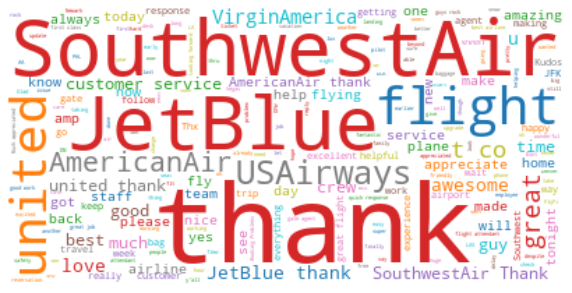

In [40]:
positive_tweets = train[train['airline_sentiment']=='positive']['text']
positive_tweets = ' '.join(positive_tweets)

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10, 8))
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(positive_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

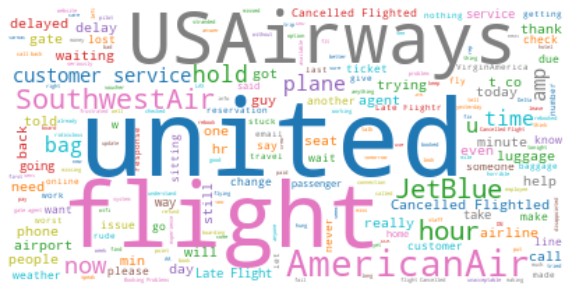

In [41]:
negative_tweets = train[train['airline_sentiment']=='negative']['text']
negative_tweets = ' '.join(negative_tweets)

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(negative_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 5. Feature engineering

As mentioned in the introduction, we will build a bag of words representation. Each feature will be a dummy variable indicating the presence of a token in a tweet. 

Fortunately, the `scikit-learn` package makes things easy for us. We just have to pass the custom tokenizer that we coded above. The `min_df=5` option means that we a token needs to appear in at least five tweets to be considered.

In [44]:
%%time 

# This may take a minute to run

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, tokenizer=tokenizer, min_df=5, binary=True)
X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])

CPU times: user 28.6 s, sys: 556 ms, total: 29.1 s
Wall time: 29.8 s


We end up with 1333 features. 

In [45]:
X_train.shape

(6227, 1330)

It's useful to retrieve the tokens that correspond to each feature. 

In [46]:
feature_names = vectorizer.get_feature_names()

This week's practice will ask you to experiment with other feature engineering approaches.  

# 6. Logistic regression

This is the main part of the tutorial where we finally train regularised linear models!

We start by fitting a logistic regression without regularisation as a benchmark. 

In [48]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none')
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

Regularisation will be probably be helpful there is a large number of features. We use the [<TT>LogisticRegressionCV<TT>](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) class, which has built-in grid search for hyperparameter optimisation 

In [49]:
from sklearn.linear_model import LogisticRegressionCV

logit_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train)

LogisticRegressionCV(penalty='l1', scoring='neg_log_loss', solver='liblinear')

L1 regularisation sets more than half of the coefficients to zero. 

In [86]:
np.sum(np.abs(logit_l1.coef_) == 0.0)

737

In [50]:
np.sum(np.abs(logit_l1.coef_) == 0.0) / len(logit_l1.coef_.flatten())

0.5541353383458647

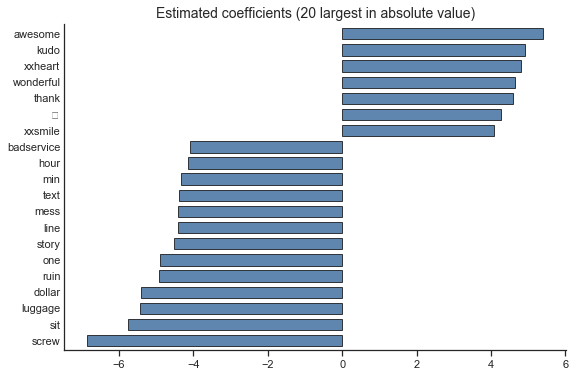

In [51]:
# Re-using the auxiliary code from Tutorial 4

from tutorial4 import coefplot
coefplot(logit_l1, feature_names)
plt.show()

The code for L2 regularisation is almost the same.

In [52]:
logit_l2 = LogisticRegressionCV(Cs=50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, scoring='neg_log_loss')

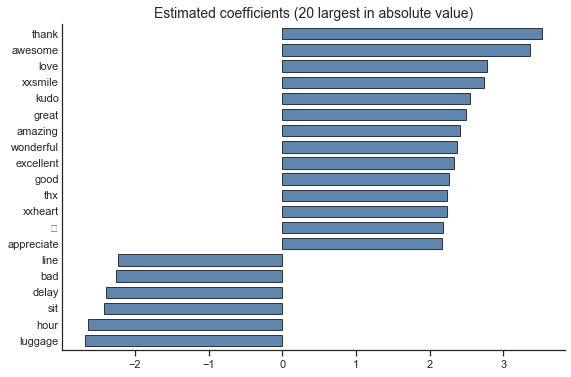

In [53]:
coefplot(logit_l2, feature_names)
plt.show()

In [54]:
np.sum(np.abs(logit_l2.coef_) == 0.0)

0

You can also do elastic net regularisation as follows, but we skip this here as it's quite slow. 

In [42]:
# logit_enet = LogisticRegressionCV(Cs=25, penalty='elasticnet', l1_ratios = [0.25, 0.5, 0.75],
#                                   solver='saga', scoring='neg_log_loss')
# logit_enet.fit(X_train, y_train)

# 7. Model stacking

The Naive Bayes classifier, which you may have learned about in a previous unit, is a standard method for text classification.  Let's include it here so that we have some diversity in our models.

In [55]:
from sklearn.naive_bayes import BernoulliNB
nbc = BernoulliNB() # this class only applies when all the predictors are binary, don't use it otherwise
nbc.fit(X_train, y_train)

BernoulliNB()

It's worth checking if we can improve accuracy by ensembling the logistic regression and Naive Bayes methods.  

In [57]:
from sklearn.ensemble import StackingClassifier

## Ideal, but slow: nested CV to select the regularisation penalty
# estimators = [
#     ('logit',  LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')),
#     ('nbc', BernoulliNB())
# ]

estimators = [
    ('logit',  LogisticRegression(C=logit_l2.C_[0], penalty='l2', solver='lbfgs')),
    ('nbc', BernoulliNB())
]


stack = StackingClassifier(estimators=estimators, cv=5, final_estimator=LogisticRegression(penalty='none'))
stack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('logit',
                                LogisticRegression(C=1.7575106248547894)),
                               ('nbc', BernoulliNB())],
                   final_estimator=LogisticRegression(penalty='none'))

I find this implementation unsatisfactory because the inputs to the meta-model are predicted probabilities. Since the meta-model is a logistic regression, it would make more sense to apply a logit transformation to the predicted probabilities before passing them as inputs to the model. 

It's possible to do this manually, but we don't want to complicate the code for now. 

# 8. Model selection

Let's use (nested) cross-validation to compare the performance of all the methods and select our final model. 

The results show that the regularisation is essential in this application. 

We select the model stack as the final model since it has the lowest cross-validation error. 

In [52]:
%%time

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss

columns=['Error rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Naive Bayes', 'Logistic', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[nbc, logit, logit_l1, logit_l2, stack]

y_prob = np.zeros((len(train), len(rows))) 

for i, method in enumerate(methods):

    y_prob[:, i] = cross_val_predict(method, X_train, y_train, method='predict_proba')[:, 1]        
    y_pred = (y_prob[:, i] > 0.5).astype(int)
    
    confusion  = confusion_matrix(y_train, y_pred) 
    results.iloc[i,0]=  1 - accuracy_score(y_train, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  precision_score(y_train, y_pred)
    results.iloc[i,4]=  roc_auc_score(y_train, y_prob[:,i])   
    results.iloc[i,5]=  log_loss(y_train, y_prob[:,i])   

results.round(3)

CPU times: user 51 s, sys: 829 ms, total: 51.9 s
Wall time: 53.1 s


,Error rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Naive Bayes,0.053,0.854,0.966,0.836,0.972,0.156
Logistic,0.074,0.832,0.946,0.758,0.944,2.226
Logistic $\ell_1$,0.057,0.812,0.970,0.847,0.971,0.162
Logistic $\ell_2$,0.051,0.802,0.979,0.888,0.976,0.139
Stack,0.047,0.825,0.979,0.890,0.976,0.139


# 9. Model evaluation

Recall that the goal of model evaluation is to estimate the generalisation performance of the final model.

It's useful to have a benchmark for model evaluation. Here, we a prediction rule that classifies all messages as negative. Because most tweets are negative, that automatically leads to an accuracy of 83% for classification, which is then what we are trying to improve on.

In [53]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['All negative', 'Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[None, stack]

y_prob = np.zeros((len(test), len(rows))) # we'll store the probabilities for later

for i, method in enumerate(methods):
    
    if i == 0: # all negative
        y_pred = np.zeros(len(y_test))
        y_prob[:, i] = np.mean(y_train)
    else:
        y_pred = method.predict(X_test)
        y_prob[:, i] = method.predict_proba(X_test)[:,1]
    

    confusion = confusion_matrix(y_test, y_pred) 
    results.iloc[i, 0] = 1 - accuracy_score(y_test, y_pred)
    results.iloc[i, 1] = confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i, 2] = confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i, 3] = precision_score(y_test, y_pred)
    results.iloc[i, 4] = roc_auc_score(y_test, y_prob[:,i])   
    results.iloc[i, 5] = log_loss(y_test, y_prob[:,i])   

results.round(3)

,Error rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
All negative,0.170,0.000,1.000,0.0,0.500,0.457
Stack,0.045,0.829,0.981,0.9,0.978,0.130


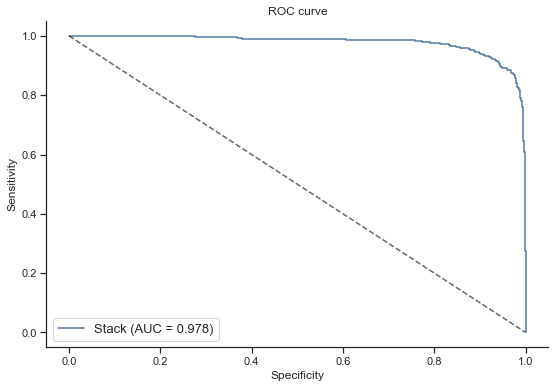

In [54]:
from tutorial4 import rocplot

fig, ax = rocplot(y_test, y_prob[:,1].reshape((-1,1)), labels=pd.Series(rows[-1]))
ax.set_title('ROC curve')
plt.show()